In [1]:
import os
import shutil
import itertools
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import cv2

DataSets : Labeled Faces in the Wild (LFW) 

Step 1: Extract all the faces which has more than one images.

In [3]:
def copy_folders_with_items(src_dir, dest_dir):
    os.makedirs(dest_dir, exist_ok=True)
    for folder_name in os.listdir(src_dir):
        folder_path = os.path.join(src_dir, folder_name)
        if os.path.isdir(folder_path):
            items = os.listdir(folder_path)
            if len(items) > 1:
                dest_path = os.path.join(dest_dir, folder_name)
                shutil.copytree(folder_path, dest_path)
                print(f"Copied: {folder_name} to {dest_dir}")
            else:
                print(f"Skipped: {folder_name} (only {len(items)} item)")

source_directory = "/home/shreyansh/Downloads/Computer Vision/lfw"
destination_directory = "/home/shreyansh/Downloads/Computer Vision/SIAM_DATA"

copy_folders_with_items(source_directory, destination_directory)

Copied: Michelle_Rodriguez to /home/shreyansh/Downloads/Computer Vision/SIAM_DATA
Skipped: Edward_Burns (only 1 item)
Copied: Gil_de_Ferran to /home/shreyansh/Downloads/Computer Vision/SIAM_DATA
Skipped: Curt_Weldon (only 1 item)
Skipped: Horace_Donovan_Reid (only 1 item)
Skipped: Cole_Chapman (only 1 item)
Skipped: Manuel_Rosendo (only 1 item)
Copied: Inocencio_Arias to /home/shreyansh/Downloads/Computer Vision/SIAM_DATA
Skipped: Brandon_Inge (only 1 item)
Skipped: Noer_Moeis (only 1 item)
Skipped: Ronald_Brower (only 1 item)
Copied: Thomas_Wyman to /home/shreyansh/Downloads/Computer Vision/SIAM_DATA
Skipped: Cora_Cambell (only 1 item)
Copied: Kieran_Prendergast to /home/shreyansh/Downloads/Computer Vision/SIAM_DATA
Copied: Joseph_Blatter to /home/shreyansh/Downloads/Computer Vision/SIAM_DATA
Skipped: Abdullah_Ahmad_Badawi (only 1 item)
Skipped: Angie_Arzola (only 1 item)
Skipped: Scott_Dickson (only 1 item)
Skipped: Alex_Corretja (only 1 item)
Copied: James_Maguire to /home/shreyansh

Step - 2 Create a paired datasets for model training

In [2]:
# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def detect_and_crop_face(image_path):
    """Detects faces in an image and returns the cropped face resized to 224x224."""
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        return None  # No face detected

    x, y, w, h = faces[0]
    face = img[y:y+h, x:x+w]
    face_resized = cv2.resize(face, (224, 224))
    return face_resized

In [3]:
def generate_train_image_pairs(source_dir):
    class_images = {}
    images_dataset = []
    labels_dataset = []

    for folder_name in os.listdir(source_dir):
        folder_path = os.path.join(source_dir, folder_name)
        if os.path.isdir(folder_path):
            images = [
                os.path.join(folder_path, f)
                for f in os.listdir(folder_path)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ]
            valid_images = [detect_and_crop_face(img) for img in images]
            valid_images = [img for img in valid_images if img is not None]
            
            images_dataset.extend(valid_images)
            labels_dataset.extend([folder_name] * len(valid_images))
    
    images_dataset = np.array(images_dataset)
    labels_dataset = np.array(labels_dataset)
    
    # Generate pairs
    unique_labels = np.unique(labels_dataset)
    label_wise_indices = {label: np.where(labels_dataset == label)[0] for label in unique_labels}
    
    pair_images = []
    pair_labels = []
    
    for index, image in enumerate(images_dataset):
        # Positive pair
        pos_indices = label_wise_indices[labels_dataset[index]]
        pos_image = images_dataset[np.random.choice(pos_indices)]
        pair_images.append((image, pos_image))
        pair_labels.append(1)

        # Negative pair
        neg_indices = np.where(labels_dataset != labels_dataset[index])[0]
        neg_image = images_dataset[np.random.choice(neg_indices)]
        pair_images.append((image, neg_image))
        pair_labels.append(0)

    return np.array(pair_images), np.array(pair_labels)

# usage
source_directory = "/home/shreyansh/Downloads/Computer Vision/SIAM_DATA"
pair_images, pair_labels = generate_train_image_pairs(source_directory)

print(f"Generated {len(pair_images)} image pairs.")
print(f"Example pair labels: {pair_labels[:5]}")

Generated 18208 image pairs.
Example pair labels: [1 0 1 0 1]


In [4]:
import numpy as np

def save_pairs_as_numpy(pair_images, pair_labels, save_path="siamese_pairs.npz"):
    img1, img2 = zip(*pair_images)
    img1 = np.array(img1)
    img2 = np.array(img2)
    np.savez_compressed(save_path, img1=img1, img2=img2, labels=pair_labels)
    print(f"Saved pairs and labels to {save_path}")

save_pairs_as_numpy(pair_images, pair_labels, save_path="siamese_pairs.npz")

Saved pairs and labels to siamese_pairs.npz


In [2]:
def preprocess_images(img_array, target_size=(128, 128)):
    preprocessed_images = []
    for img in img_array:
        resized_img = cv2.resize(img, target_size)
        # if len(resized_img.shape) > 2:
        #     resized_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
        preprocessed_images.append(resized_img)
    return np.array(preprocessed_images)

In [3]:
def load_pairs_from_numpy(file_path="siamese_pairs.npz"):
    data = np.load(file_path)
    img1 = data['img1']
    img2 = data['img2']
    labels = data['labels']
    print(f"Loaded {len(labels)} pairs from {file_path}")
    return img1, img2, labels

img1, img2, labels = load_pairs_from_numpy("siamese_pairs.npz")
img1 = preprocess_images(img1).astype('float32') / 255.0
img2 = preprocess_images(img2).astype('float32') / 255.0
print(f"Shape of img1: {img1.shape}, img2: {img2.shape}, labels: {labels.shape}")

Loaded 18208 pairs from siamese_pairs.npz
Shape of img1: (18208, 128, 128, 3), img2: (18208, 128, 128, 3), labels: (18208,)


In [4]:
from collections import Counter

In [5]:
Counter(labels)

Counter({np.int64(1): 9104, np.int64(0): 9104})

In [8]:
img1[0]

array([[[0.41960785, 0.26666668, 0.11372549],
        [0.42352942, 0.27058825, 0.11372549],
        [0.42745098, 0.27450982, 0.10980392],
        ...,
        [0.05098039, 0.09019608, 0.09019608],
        [0.05882353, 0.09019608, 0.09019608],
        [0.06666667, 0.09803922, 0.09803922]],

       [[0.42352942, 0.27058825, 0.10980392],
        [0.42352942, 0.27450982, 0.10980392],
        [0.42352942, 0.27450982, 0.10588235],
        ...,
        [0.05098039, 0.08627451, 0.08627451],
        [0.0627451 , 0.09411765, 0.09411765],
        [0.06666667, 0.09803922, 0.09803922]],

       [[0.41568628, 0.2784314 , 0.10196079],
        [0.41568628, 0.2784314 , 0.10196079],
        [0.41568628, 0.28235295, 0.10196079],
        ...,
        [0.04705882, 0.09019608, 0.09411765],
        [0.05490196, 0.09019608, 0.09803922],
        [0.0627451 , 0.09803922, 0.09803922]],

       ...,

       [[0.04705882, 0.0627451 , 0.04313726],
        [0.05490196, 0.07058824, 0.05098039],
        [0.05882353, 0

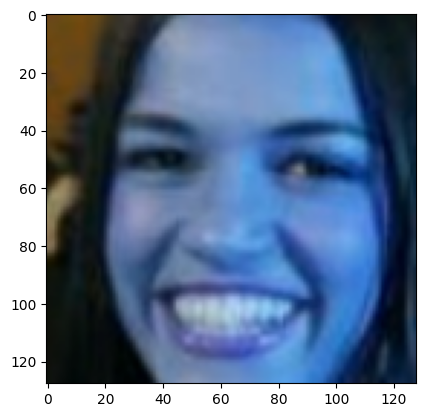

In [14]:
plt.imshow(img1[0])

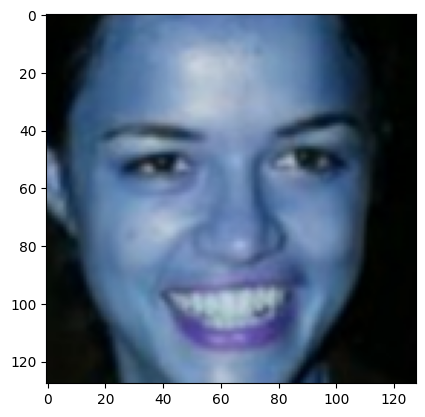

In [15]:
plt.imshow(img2[0])

In [6]:
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import numpy as np
import tensorflow as tf

2024-12-13 10:59:03.308702: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-13 10:59:03.319617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734067743.331612  118823 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734067743.335063  118823 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 10:59:03.347467: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [7]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [20]:
def build_siamese_model(input_shape=(128, 128, 3)):
    base_model = EfficientNetV2S(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = False
    
    inputs = Input(shape=input_shape)
    x = base_model(inputs)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    # x = Dense(128, activation='relu')(x)
    # x = layers.Dropout(0.2)(x)
    # x = layers.BatchNormalization()(x)
    outputs = Dense(128, activation='relu')(x)
    
    feature_extractor = Model(inputs, outputs)
    
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    
    embedding_a = feature_extractor(input_a)
    embedding_b = feature_extractor(input_b)

    distance = Lambda(
        lambda tensors: tf.sqrt(tf.reduce_sum(tf.square(tensors[0] - tensors[1]), axis=1, keepdims=True)),
        output_shape=(1,)
    )([embedding_a, embedding_b])
    similarity = Dense(1, activation='sigmoid')(distance)
    
    siamese_model = Model(inputs=[input_a, input_b], outputs=similarity)
    
    # base_model.trainable = True
    # for layer in base_model.layers[:-3]:
    #     layer.trainable = False
    
    return siamese_model

In [21]:
siamese_model = build_siamese_model()
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(),
                          loss='binary_crossentropy',
                          metrics=['accuracy'])
siamese_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_6        │ (None, 128)       │ 30,984,928 │ input_layer_14[0… │
│ (Functional)        │                   │            │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 1)         │          0 │ functional_6[0][… │
│                     │                   │            │ functional_6[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1)         │          2 │ lambda_3[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,984,930 (118.20 MB)

 Trainable params: 10,652,034 (40.63 MB)

 Non-trainable params: 20,332,896 (77.56 MB)

In [17]:
from sklearn.model_selection import train_test_split

img1_train, img1_temp, img2_train, img2_temp, labels_train, labels_temp = train_test_split(
    img1, img2, labels, test_size=0.3, random_state=42
)

img1_val, img1_test, img2_val, img2_test, labels_val, labels_test = train_test_split(
    img1_temp, img2_temp, labels_temp, test_size=0.5, random_state=42
)

print(f"Training set: {len(img1_train)} samples")
print(f"Validation set: {len(img1_val)} samples")
print(f"Test set: {len(img1_test)} samples")

Training set: 12745 samples
Validation set: 2731 samples
Test set: 2732 samples


In [19]:
labels_train

array([1, 0, 1, ..., 1, 1, 0])

In [22]:
history = siamese_model.fit(
    [img1_train, img2_train], labels_train,
    validation_data=([img1_val, img2_val], labels_val),
    batch_size=512,
    epochs=25,
    verbose=1
)

Epoch 1/25


/data1/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_2110', 'keras_tensor_2111']. Received: the structure of inputs=('*', '*')
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 167s 4s/step - accuracy: 0.5018 - loss: 2.8839 - val_accuracy: 0.5895 - val_loss: 0.9141
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 714ms/step - accuracy: 0.4991 - loss: 1.4889 - val_accuracy: 0.5895 - val_loss: 0.7304
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 733ms/step - accuracy: 0.5016 - loss: 0.8221 - val_accuracy: 0.5903 - val_loss: 0.6866
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 726ms/step - accuracy: 0.4960 - loss: 0.7169 - val_accuracy: 0.5881 - val_loss: 0.6868
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 746ms/step - accuracy: 0.5004 - loss: 0.7027 - val_accuracy: 0.5456 - val_loss: 0.6891
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 728ms/step - accuracy: 0.4986 - loss: 0.6962 - val_accuracy: 0.5950 - val_loss: 0.6846
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 722ms/step - accuracy: 0.5108 - loss: 0.6961 - val_accuracy: 0.5364 - val_loss: 0.6902
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 723ms/step - accuracy: 0.5091 - loss: 0.6954 - val_accuracy: 0.5317 

In [23]:
siamese_model.save('siamese.keras')

In [24]:
predictions = siamese_model.predict([img1_test, img2_test], batch_size=512).flatten()
binary_predictions = (predictions > 0.5).astype(int)
binary_predictions

6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step 


array([0, 1, 1, ..., 0, 0, 0])

In [25]:
set(binary_predictions)

{np.int64(0), np.int64(1)}

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

true_labels = labels_test

# Accuracy
accuracy = accuracy_score(true_labels, binary_predictions)
print("Accuracy:", accuracy)

# Precision, Recall, F1-Score
precision = precision_score(true_labels, binary_predictions)
recall = recall_score(true_labels, binary_predictions)
f1 = f1_score(true_labels, binary_predictions)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.5563689604685212
Precision: 0.556870479947403
Recall: 0.6115523465703971
F1 Score: 0.5829318651066758
